# PREDICTING SALES OF ROSSMANN DRUGSTORES

# 1. Problem Description

Sales forecasting is a common challenge for all kinds of businesses. It is often used as a starting point for drawing up an annual budget, a business expansion and, more generally, a plan to fuel the company's growth. Therefore, sales forecasting is a very important part of any business strategy that affects everyone in the organization. Yet for most companies coming up with an accurate sales forecast is still a major challenge.

This notebook is an example of a sales forecasting problem. It is a regression problem where the goal is to predict the sales of Rossmann drugstores for the next six weeks. 

Rossmann operates over 3,000 drugstores in 7 European countries. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

With the aim of improving the accuracy of the predictions, a Kaggle competition was opened in 2015 in order to provide Rossman with an accurate sales forecast model. The competiton finished with 0.10021 as the best score, measured in root mean square percentage error (RMSPE). This notebook is an attempt to reach a score approching this value by testing a variety of regression models.

In particular, an attempt was made to encapsulate all stages of a typical data pre-processing step in their respective custom scikit-learn transformers, which were then grouped together in a pipeline.

Other salient points of this notebook are the necessity of a custom times series cross-validation scheme (as a standard k-fold would be inappropriate for a time series) and bayesian hyperparameter tuning with Optuna.

Here is a summary of the variables available in the raw data:

* Store: a unique Id for each store
* Sales: the turnover for any given day
* Customers: the number of customers on a given day. This variable will not be avaible at the time of prediction, therefore it is not used in the model.
* Open: an indicator for whether the store was open: 0 = closed, 1 = open
* StateHoliday: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools
* StoreType: differentiates between 4 different store models: a, b, c, d
* Assortment: describes an assortment level: a = basic, b = extra, c = extended
* CompetitionDistance: distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year]: gives the approximate year and month of the time the nearest competitor was opened
* Promo: indicates whether a store is running a promo on that day
* Promo2: a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week]: describes the year and calendar week when the store started participating in Promo2
* PromoInterval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store


# 2. Imports and Helper Functions

In [160]:
import math
import numpy  as np
import pandas as pd
import warnings
import inflection
import seaborn as sns
from string import ascii_letters

import datetime
import missingno as msno

from scipy import stats as ss
from matplotlib                import pyplot as plt

from sklearn.metrics           import mean_squared_error
from sklearn.ensemble          import RandomForestRegressor
from sklearn.linear_model      import LinearRegression, Lasso
from sklearn.preprocessing     import RobustScaler, OneHotEncoder
from sklearn.impute            import SimpleImputer
from sklearn.pipeline          import Pipeline
from sklearn.compose           import TransformedTargetRegressor
from sklearn.linear_model      import LinearRegression
from sklearn.base              import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from sklearn.ensemble          import HistGradientBoostingRegressor
from sklearn.model_selection   import cross_validate

import xgboost as xgb
from lightgbm                  import LGBMRegressor

import optuna
from   optuna.integration        import LightGBMPruningCallback

warnings.filterwarnings('ignore')

%matplotlib inline

Here are defined some helper functions that are used in the notebook.

The first function transforms the column names of the raw data to snake case. The second one aggregates the results of cross-validation and generates a dataframe for ease of analysis. 

In [2]:
def column_names_to_snake_case(df):
    df.columns = [inflection.underscore(c) for c in df.columns]
    return df

def cv_results_to_dataframe(cv_results, model_name):

    scores = ['test_neg_mean_absolute_error', 'test_neg_mean_absolute_percentage_error', 'test_neg_root_mean_squared_error', 'fit_time', 'score_time']

    for score in scores:
        MAE_mean = -np.round(cv_results['test_neg_mean_absolute_error'].mean(), 2)
        MAE_std = np.round(cv_results['test_neg_mean_absolute_error'].std(), 2)

        MAPE_mean = -np.round(cv_results['test_neg_mean_absolute_percentage_error'].mean(), 2)
        MAPE_std = np.round(cv_results['test_neg_mean_absolute_percentage_error'].std(), 2)

        RMSE_mean = -np.round(cv_results['test_neg_root_mean_squared_error'].mean(), 2)
        RMSE_std = np.round(cv_results['test_neg_root_mean_squared_error'].std(), 2)

        mean_fit_time = np.round((cv_results['fit_time'].mean())/60, 2)
        std_fit_time = np.round((cv_results['fit_time'].std())/60, 2)

        score_time = np.round((cv_results['score_time'].mean())/60, 2)
        std_score_time = np.round((cv_results['score_time'].std())/60, 2)

        return pd.DataFrame( {'Model Name': model_name,
                            'MAE CV': MAE_mean.astype( str ) + ' +/- ' + MAE_std .astype( str ),
                            'MAPE CV': MAPE_mean.astype( str ) + ' +/- ' + MAPE_std.astype( str ),
                            'RMSE CV': RMSE_mean.astype( str ) + ' +/- ' + RMSE_std.astype( str ),
                            'Mean Fit Time (min)': mean_fit_time.astype( str ) + ' +/- ' + std_fit_time.astype( str ),
                            'Mean Score Time (min)': score_time.astype( str ) + ' +/- ' + std_score_time.astype( str )}
                            , index=[0])

Here it is also important to define a class that will deal with cross-validation indeces generation. This will prove to be very useful down the line.

In general, a k-fold cross-validation scheme can be used in simple cases to evaluate the performance of a model for supervised machine learning. The scikit-learn `KFold` iterator divides all samples in groups, called folds, of equal sizes (if possible). The prediction function is learned using `k - 1` folds, and the fold left out is used for validation.

However, time series data is characterized by correlation between observations that are near in time (autocorrelation). Classical cross-validation techniques such as `KFold` assume that the samples are independent and identically distributed. Therefore, using `KFold` would result in unreasonable correlation between training and testing instances (yielding poor estimates of generalization error) on time series data. It is very important to evaluate models for time series data on “future” observations least like those that are used to train the model.

The class `TimeSeriesCV` below is an attempt to address this issue. It is a cross-validation iterator, specifically created for this dataset, that provides train/test indices to split time series data. Unlike standard cross-validation methods, successive training sets are supersets of those that come before them. As it uses the `date` column of the data set, the iterator is capable of creating splits that take into account the testing period desired (in this case, six weeks) and a gap between the training and testing periods (in this notebook, 2 weeks will be used). A gap is necessary to avoid creating a training set too close to the start of the testing set, which would result in a training set that contains too much information from the testing set.

Another problem that this cv-iterator tries to address is the existence of multiple entries for the same timestamp. This was circumvented using the `date` column explicitly in the split method. As a result, samples can be taken at irregular time intervals and multiple samples per timestamp are allowed.

In [3]:
class TimeSeriesCV:
    """ A cross-validation generator specifically created for time series 
    containing a 'date' column with frequency in days.

    Provides train/test indices to split time series data samples in train/test
    sets. Samples can be observed at irregular time intervals. Multiple samples per
    timestamp are allowed.

    This cross-validation object is a variation of class 'KFold'.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set. Note that unlike standard cross-validation methods,
    successive training sets are supersets of those that come before them.

    It should be used inside a pipeline that drops the 'date' column during 
    preprocessing.

    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.

    test_size : int, default=42
        Used to limit the size of the test set. Default is 42 days, or 6 weeks. 
        
    gap : int, default=0
        Number of DAYS to exclude from the end of each train set before
        the test set.
    """

    def __init__(self, n_splits=5, test_size=42, gap=0):
        self.n_splits = n_splits
        self.test_size = test_size
        self.gap = gap

    def split(self, X, y=None, groups=None):

        n_splits = self.n_splits
        n_folds = n_splits + 1
        test_size = self.test_size
        gap = self.gap

        X.index = np.arange(X.shape[0])

        for k in range(1, n_folds):

            test_start_date = X['date'].max() - datetime.timedelta(days= k * test_size)
            test_end_date = X['date'].max() - datetime.timedelta(days= (k-1) * test_size)

            train_end_date = test_start_date - datetime.timedelta(days=gap)

            train_index = X[X['date'] < train_end_date].index.values
            test_index = X[(X['date'] >= test_start_date) & (X['date'] <= test_end_date)].index.values

            yield train_index, test_index

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

# 3. Data Preparation

## 3.1 Importing data

Two files were provided in the competition. One contains data with the sales for each store for each day of the year, along with some information about holidays. The other contains information about each store store, such as competition distance, assortment, etc. For ease of handling, the data was merged into a single dataframe.

Only data entries for which stores are open and sales are not zero were considered for training. 

In [4]:
df_sales_raw = pd.read_csv('/Users/lucasstelmastchuk/Documents/repos/rossman_sales/data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('/Users/lucasstelmastchuk/Documents/repos/rossman_sales/data/store.csv', low_memory=False)

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

df = df_raw.copy()
df = df[df['Open'] == 1]
df = df[df['Sales'] > 0]
df = df.reset_index(drop=True)
column_names_to_snake_case(df)
df['date'] = pd.to_datetime(df['date'])


X_train = df.drop(['sales', 'customers'], axis=1).copy()
y_train = df['sales'].copy()

print(f'Number of rows: {df.shape[0]}')
print(f'Number of columns: {df.shape[1]}')
df.sample()

Number of rows: 844338
Number of columns: 18


,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
135545,630,5,2015-03-06,8164,914,1,1,0,0,a,a,1690.0,4.0,2015.0,0,NaN,NaN,NaN


Here the same procedure is applied to the test data provided by Kaggle. This will be used to generate the submission file and will serve as the ultimate test set to evaluate the model. As such, the train data imported above will be used completely for training the model and a reasonable estimate of the generalization error will be obtained by cross validaton on the train set.

In [6]:
df_sales_test = pd.read_csv('/Users/lucasstelmastchuk/Documents/repos/rossman_sales/data/test.csv', low_memory=False)
df_raw_test = pd.merge(df_sales_test, df_store_raw, how='left', on='Store')
column_names_to_snake_case(df_raw_test)
X_test = df_raw_test.drop(['id'], axis=1).copy()
X_test['date'] = pd.to_datetime(X_test['date'])
X_test.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,7,4,2015-09-17,1.0,1,0,0,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
3,8,4,2015-09-17,1.0,1,0,0,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
4,9,4,2015-09-17,1.0,1,0,0,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN


## 3.2 Dealing with missing values

The following graph shows the amount of missing values for each column in the dataframe. The percentage of missing values is relatively low, which is expected, as the data was certainly pre-processed for the competition.

There are just five columns with many missing values: competition_open_since_year, competition_open_since_month, promo_2_since_week, promo_2_since_year and promo_interval. There are also very few missing values in the competition distance column, which are not apparent in the graph as the percentage is too low.


<AxesSubplot:>

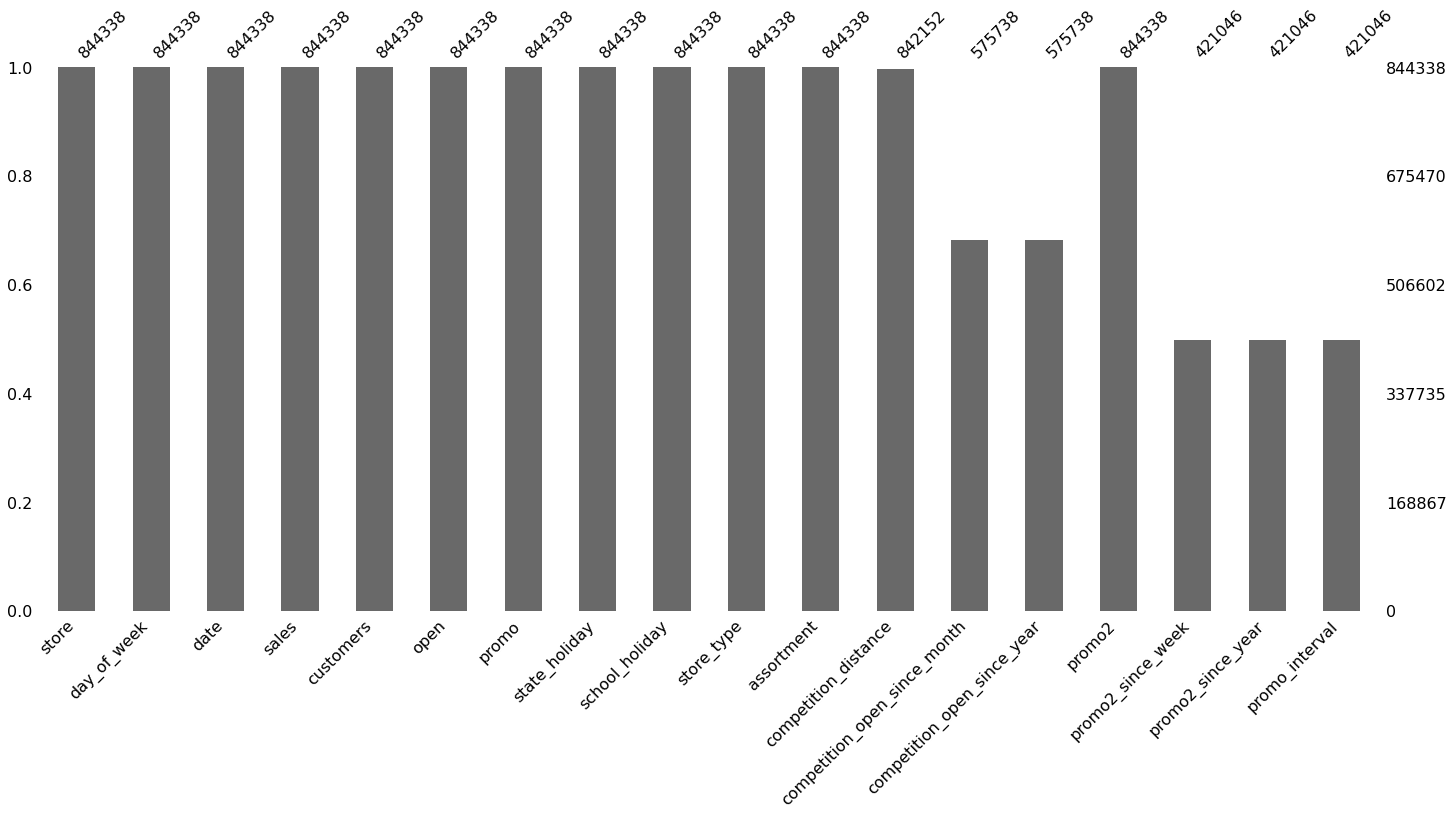

In [7]:
msno.bar(df)

The next image shows the position of the missing values in the dataset as blank lines. It shows that missing values in the competition_open_since_month and the competition_open_since_year columns are correlated the same thing happen with missing values in the promo_2_since_week, promo_2_since_year and promo_interval columns. As these columns relate to the same date (competiton opening and promo 2 starting), it is not surprising that missing values appear together. 

It is important to note that because almost all stores have a competitor (indicated by very few missing values in the competition distance column), missing values in the two columns that indicate the competition opening date are related to real lack of information, i. e. there is a date of opening, but we don't know it. Missing values that relate to the start of promo 2 and promo 2 interval, however, just indicate that the store is not participating in promo 2.

<AxesSubplot:>

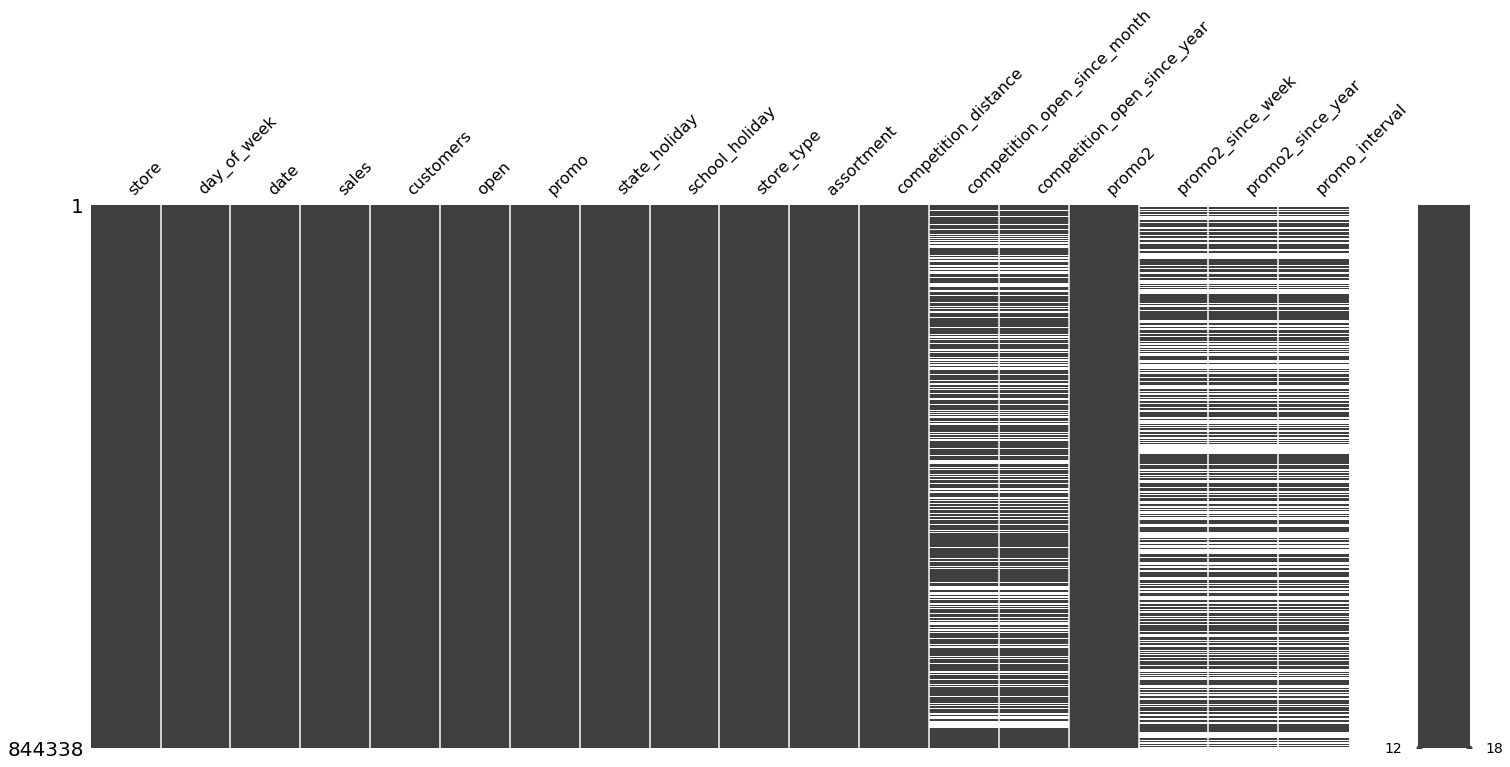

In [8]:
msno.matrix(df)

The following strategy was adopted to deal with missing values:

* competition_distance:
    There are very few missing values here. It will be assumed that the competitor will be very far away (200,000 meters) for these stores.

* competition_open_since_month and competition_open_since_year:
    Imputation of the median competition opening month and year for stores with no information about competition opening date.

* promo_2_since_week and promo_2_since_year:
    Missing values will be replaced with the current date so that the total elapsed time for these stores since the start of the promotion 2 will always be zero 0. This will become clear when the feature weeks_since_promo2_started is created (see next section).

The missing value imputation will be encapsulated in a single custom transformer. In order to integrate it with the rest of the pipeline, it implementrs the `fit` and `transform` method.
    

In [10]:
class MissingValueImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        
        self.competition_open_since_month_imputer = SimpleImputer(strategy='median').fit(X[['competition_open_since_month']])
        self.competition_open_since_year_imputer = SimpleImputer(strategy='median').fit(X[['competition_open_since_year']])
        
        return self
    
    def transform(self, X):
        
        X = X.copy()

        # FILLING IN MISSING VALUES
        # Maximum competition distance is 75,860 meters. Considering that missing values are probably related to stores with
        # no competition nearby, these stores will get the value 200,000 meters to indicate that competitors are far away.      
        X['competition_distance'] = X['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        # Imputation of the median competition opening month and year for stores with no information about competition opening date.
        # Note that missing values here do not represent absence of competition, but absence of information about competition opening date,
        # as competion distance have very few missing values.
        X['competition_open_since_month'] = self.competition_open_since_month_imputer.transform(X[['competition_open_since_month']])
        X['competition_open_since_year'] = self.competition_open_since_year_imputer.transform(X[['competition_open_since_year']])

        # Missing values for start of promo2 are linked to stores that do not participate in this second type of promotion at any given year.
        # Missing values will be replaced with the current date so that the total elapsed time for these stores since the start of the 
        # promotion 2 will always be zero 0 (see feature engineering section).
        X['promo2_since_week'] = X.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)
        X['promo2_since_year'] = X.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)
        
        return X

## 3.3 Creating time features

The `AttributesAdder` class is a custom transformer that adds time features to the dataframe.

The date column cannot be used as a feature directly, as it is not a continuous variable. Therefore, the following features are created:

* month: month of the year (1 = January, 12 = December)
* day_of_month: day of the month (1 = 1st, 31 = 31st)
* week_of_year: week of the year
* is_weekend: 1 if the day is a weekend, 0 otherwise

Two features are created to indicate the time since the competition was opened and the time since promotion 2 started:

* months_since_competition_opened
* weeks_since_promo2_started.

The original features were discarded after transformation.

Transforming the features derived from the date column into cyclical features, i. e. trigonometric transformations, might improve the performance of the model. As we cannot be certain whether there is in fact a improvement or not, a parameter was added to the `AttributesAdder` class to control the transformation. If `True`, the trigonometric transformations will be applied and the original features will be deleted. This parameter will be part of the full pipeline, which allows us to tune it during hyperparameter optimization.

Dealing with promo_interval is a bit more convoluted, as the business logic is a bit obscure. From the information given on Kaggle's webpage, we can see that promotion 2 is independent of promotion 1, and a store can be in promotion 1 and promotion 2 at the same time. Some stores never take part in promotion 2, but those that do have a fixed recurrent interval between start and finish that lasts for three months. So if a store starts promotion 2 in January, it will finish it by March, so that on April a new cycle of promotion 2 starts. The next cycles for this store starts on July and October. This way a whole year is covered by 4 cycles of promotion 2. To complicate matters, stores may have different start months, which gives three possibilities: the first cycle of promotion 2 may start in January, February or March. 

Promotion 2 might be a loyalty program that encourages clients to spend more on the same store in order to accumulate bonus points. As we don't have much more information about what kind of promotion it is, the best option is to tentatively include it in the model. A way to condense this information is to indicate for each data entry of the time series whether the store is currently in the first (1), second (2) or third (3) month of any given cyle. If the store doesn't participate in promotion 2, the promo_interval will be 0. This transformation is applied in the `transform` method by the private method `_transform_promo_interval` inside the class `AttributesAdder`.

In [11]:
class AttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self,  cyclical_features=True):
        self.cyclical_features = cyclical_features
    
    def fit(self, X, y=None):
        return self
    
    def _transform_promo_interval(self, x):
            if x['promo_interval'] == 'Jan,Apr,Jul,Oct':
                if x['date'].month in [1, 4, 7, 10]:
                    return 1
                elif x['date'].month in [2, 5, 8, 11]:
                    return 2
                elif x['date'].month in [3, 6, 9, 12]:
                    return 3
            elif x['promo_interval'] == 'Feb,May,Aug,Nov':
                if x['date'].month in [2, 5, 8, 11]:
                    return 1
                elif x['date'].month in [3, 6, 9, 12]:
                    return 2
                elif x['date'].month in [1, 4, 7, 10]:
                    return 3
            elif x['promo_interval'] == 'Mar,Jun,Sept,Dec':
                if x['date'].month in [3, 6, 9, 12]:
                    return 1
                elif x['date'].month in [1, 4, 7, 10]:
                    return 2
                elif x['date'].month in [2, 5, 8, 11]:
                    return 3
            else:
                return 0

    def _sin_transform(self, col, period):
                return np.sin(2*np.pi*col/period)
            
    def _cos_transform(self, col, period):
                return np.cos(2*np.pi*col/period)

    def transform(self, X):
        
        X = X.copy()

        # Extract features from date column
        X['month'] = X['date'].dt.month
        X['day_of_month'] = X['date'].dt.day
        X['week_of_year'] = X['date'].dt.isocalendar().week
        X['is_weekend'] = X['date'].dt.weekday > 4
        X['is_weekend'] = X['is_weekend'].astype(int)
        
        # Correct data types
        X['competition_open_since_month'] = X['competition_open_since_month'].astype(int)
        X['competition_open_since_year'] = X['competition_open_since_year'].astype(int)
        X['promo2_since_week'] = X['promo2_since_week'].astype(int)
        X['promo2_since_year'] = X['promo2_since_year'].astype(int)

        # Combine year and month of competition opening and then calculate the elapsed time in months since competition opened.
        X['competition_since_date'] = X.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],
                                                                            month=x['competition_open_since_month'],
                                                                            day=1), axis=1)
        X['months_since_competition_opened'] = ((X['date'] - X['competition_since_date'])/pd.Timedelta('30 days')).astype(int)
        X['months_since_competition_opened'] = X['months_since_competition_opened'].apply(lambda x: 0 if x < 0 else x)

        # promo since
        X['promo2_since_date'] = X['promo2_since_year'].astype(str) + '-' + X['promo2_since_week'].astype(str)
        X['promo2_since_date'] = X['promo2_since_date'].apply(lambda x: datetime.datetime.strptime(x + '-0', '%Y-%W-%w'))
        X['weeks_since_promo2_started'] = ((X['date'] - X['promo2_since_date'])/pd.Timedelta('7 days')).astype(int)
        X['weeks_since_promo2_started'] = X['weeks_since_promo2_started'].apply(lambda x: 0 if x < 0 else x)

        # promo interval
        X['promo_interval'] = X[['date', 'promo_interval']].apply(lambda y: self._transform_promo_interval(y), axis=1)

        # Drop unnecessary columns
        X.drop(['date','open', 'competition_open_since_month', 'competition_open_since_year', 
                'promo2_since_week', 'promo2_since_year', 'competition_since_date', 'promo2_since_date'], 
                axis=1, inplace=True)

        # Add cyclical features
        if self.cyclical_features:
            
            X['sin_month'] = self._sin_transform(X['month'], 12)
            X['cos_month'] = self._cos_transform(X['month'], 12)
            
            X['sin_day_of_month'] = self._sin_transform(X['day_of_month'], 30)
            X['cos_day_of_month'] = self._cos_transform(X['day_of_month'], 30)

            X['sin_day_of_week'] = self._sin_transform(X['day_of_week'], 7)
            X['cos_day_of_week'] = self._cos_transform(X['day_of_week'], 7)


            X['sin_week_of_year'] = self._sin_transform(X['month'], 52)
            X['cos_week_of_year'] = self._cos_transform(X['month'], 52)
  
            X.drop(['month', 'day_of_month', 'day_of_week', 'week_of_year'], axis=1, inplace=True)
            
        return X

## 3.4 Scaling continuous features

The features competition_distance, months_since_competition_opened and weeks_since_promo2_started are scaled using `RobustScaler` from scikit-learn inside the  `Scaler` transformer.

In [12]:
class Scaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        self.competition_distance_scaler = RobustScaler().fit(X[['competition_distance']])
        self.months_since_competition_opened_scaler = RobustScaler().fit(X[['months_since_competition_opened']])
        self.weeks_since_promo2_started_scaler = RobustScaler().fit(X[['weeks_since_promo2_started']])
        return self
    
    def transform(self, X):
        
        X = X.copy()

        # SCALING NUMERICAL FEATURES
        X['competition_distance'] = self.competition_distance_scaler.transform(X[['competition_distance']]).ravel()
        X['months_since_competition_opened'] = self.months_since_competition_opened_scaler.transform(X[['months_since_competition_opened']]).ravel()
        X['weeks_since_promo2_started'] = self.weeks_since_promo2_started_scaler.transform(X[['weeks_since_promo2_started']]).ravel()

        return X

## 3.4 Encoding categorical features

Assortment, state_holiday and store_type are categorical features that need encoding in order to be compatible with machine learning algorithms, especially linear models. They will be encoded in the `Encoder` transformer defined below.

The assortment variable has a natural order for its values (a = basic, b = extra, c = extended), so it is proper to apply ordinal encoding. A store with basic assortment will have a value of 1, a store with extra assortment will have a value of 2 and a store with extended assortment will have a value of 3.

State_holiday can assume four values (public holiday, easter, christmas and not a holiday). These values will be encoded with one-hot encoding. As this variable has rare instances (just one easter and one christmas per year), it is necesary to set handle_unknown='ignore' to avoid an error when a holiday in not present in the test set.

We don't have much information about the store types other than its four possible categories, with no distinction in order specified. This information will be encoded with one-hot encoding.

In [13]:
class Encoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        
        self.state_holiday_encoder = OneHotEncoder(handle_unknown='ignore').fit(X[['state_holiday']])
        self.state_holiday_new_columns = self.state_holiday_encoder.get_feature_names_out()

        self.store_type_encoder = OneHotEncoder(handle_unknown='ignore').fit(X[['store_type']])
        self.store_type_new_columns = self.store_type_encoder.get_feature_names_out()

        return self
    
    def transform(self, X):
        
        X = X.copy()

        # ENCODING CATEGORICAL FEATURES
        X['assortment'] = X['assortment'].map({'a': 1, 'b': 2, 'c': 3})
        X['state_holiday'] = X['state_holiday'].map({'a': 'public_holiday', 'b': 'easter', 'c': 'christmas', '0': 'not_holiday'})

        state_holiday_encoded = pd.DataFrame(self.state_holiday_encoder.transform(X[['state_holiday']]).toarray(), columns=self.state_holiday_new_columns, index=X.index)

        store_type_encoded = pd.DataFrame(self.store_type_encoder.transform(X[['store_type']]).toarray(), columns=self.store_type_new_columns, index=X.index)

        X = pd.concat([X, state_holiday_encoded, store_type_encoded], axis=1).drop(['store_type', 'state_holiday'], axis=1)

        return X

# 4. Exploratory Data Analysis

In this section a brief overview of the data is given. It is far from an exhaustive analysis, but it can help us understand the data and to decide whether we need to exclude redundant features, transform the target variable or include new features.

In order to get clean data for the analysis, the following trasnsformers are used:

In [98]:
X_eda = MissingValueImputer().fit_transform(X_train)
X_eda = AttributesAdder(cyclical_features=False).fit_transform(X_eda)
df_eda = pd.concat([X_eda, df['sales']], axis=1)
df_eda.head(10)

,store,day_of_week,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,promo2,promo_interval,month,day_of_month,week_of_year,is_weekend,months_since_competition_opened,weeks_since_promo2_started,sales
0,1,5,1,0,1,c,a,1270.0,0,0,7,31,31,0,84,0,5263
1,2,5,1,0,1,a,a,570.0,1,1,7,31,31,0,94,277,6064
2,3,5,1,0,1,a,a,14130.0,1,1,7,31,31,0,105,224,8314
3,4,5,1,0,1,c,c,620.0,0,0,7,31,31,0,71,0,13995
4,5,5,1,0,1,a,a,29910.0,0,0,7,31,31,0,4,0,4822
5,6,5,1,0,1,a,a,310.0,0,0,7,31,31,0,20,0,5651
6,7,5,1,0,1,a,c,24000.0,0,0,7,31,31,0,28,0,15344
7,8,5,1,0,1,a,a,7520.0,0,0,7,31,31,0,10,0,8492
8,9,5,1,0,1,a,c,2030.0,0,0,7,31,31,0,182,0,8565
9,10,5,1,0,1,a,a,3160.0,0,0,7,31,31,0,71,0,7185


Now we can plot the correlation matrix to see which features are correlated with sales.

<AxesSubplot:>

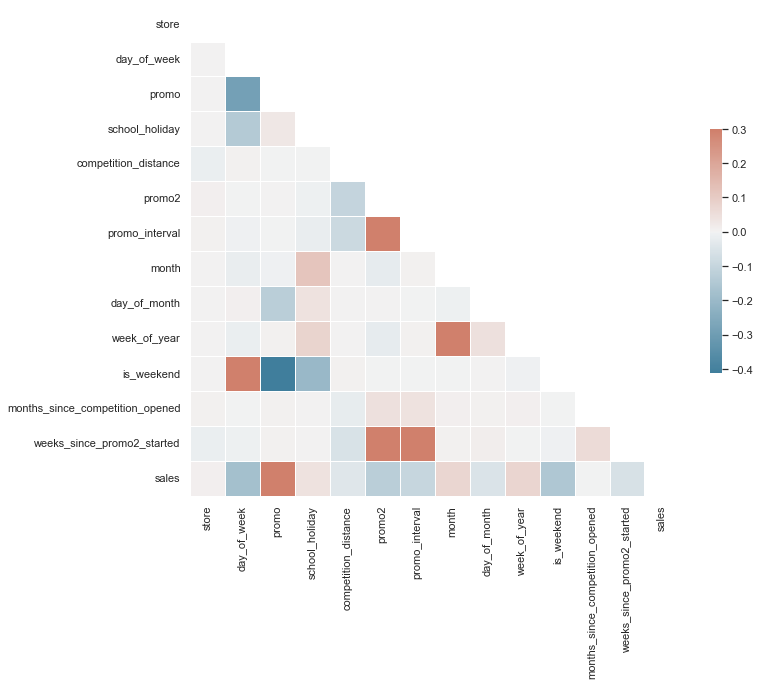

In [89]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = df_eda.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

From the plot we see that there is some correlation between sales and promotion 1. Also, there are pairs of correlation between closely related features, promo 2 and weeks since promo 2 started. This redundancy is a problem for linear models such as linear regression, so a sort of feature selection should be done for these models.in

However, the correlation matrix is certainly not a good indicator of non-linear relationship between features. After training tree-based models, it will become clear that there is non-linearity indeed. 

The plot below shows histograms of the numerical features.

<Figure size 1440x720 with 0 Axes>

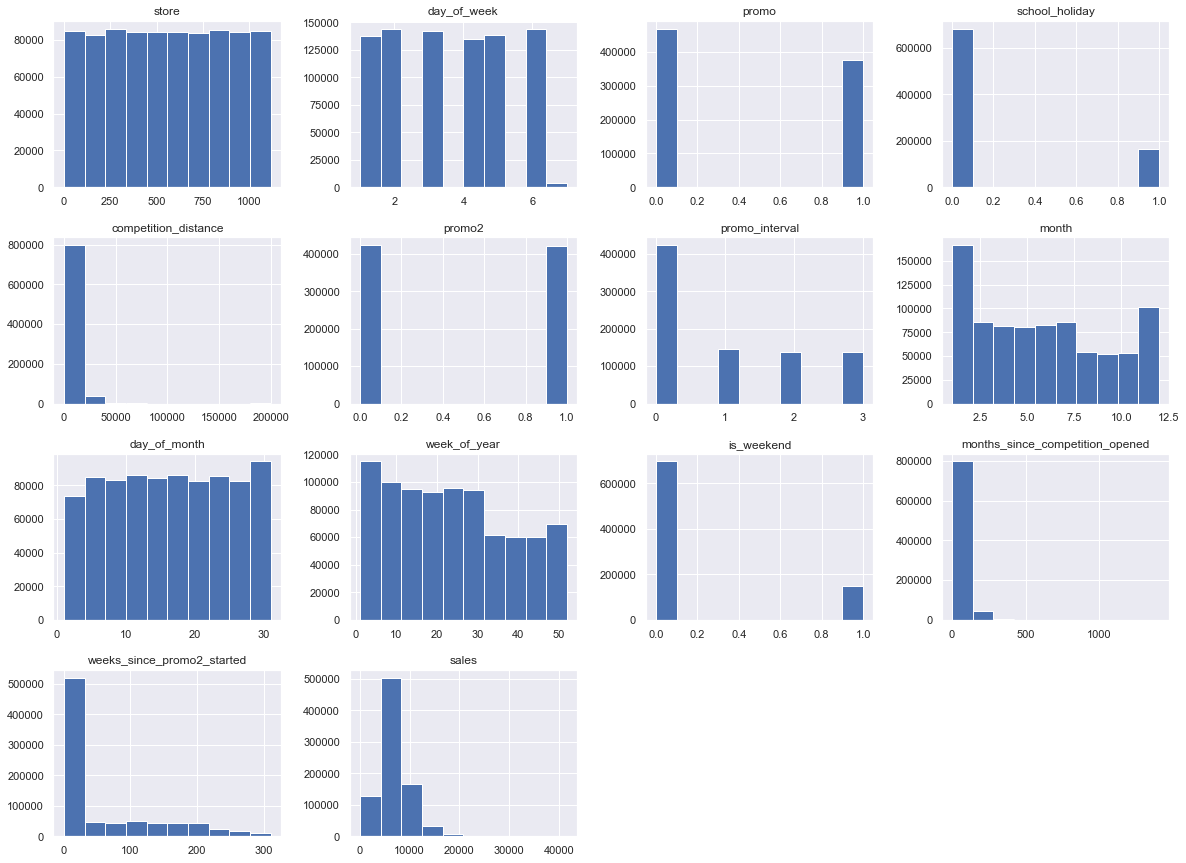

In [105]:
sns.set()
plt.figure(figsize=(20, 10))
df_eda.hist(bins=10, figsize=(20, 15))
plt.show()

Plotting the response variable in more detail, we can see that it has an elongated right tail. In order to deal with this, we will use a logarithmic transformation.

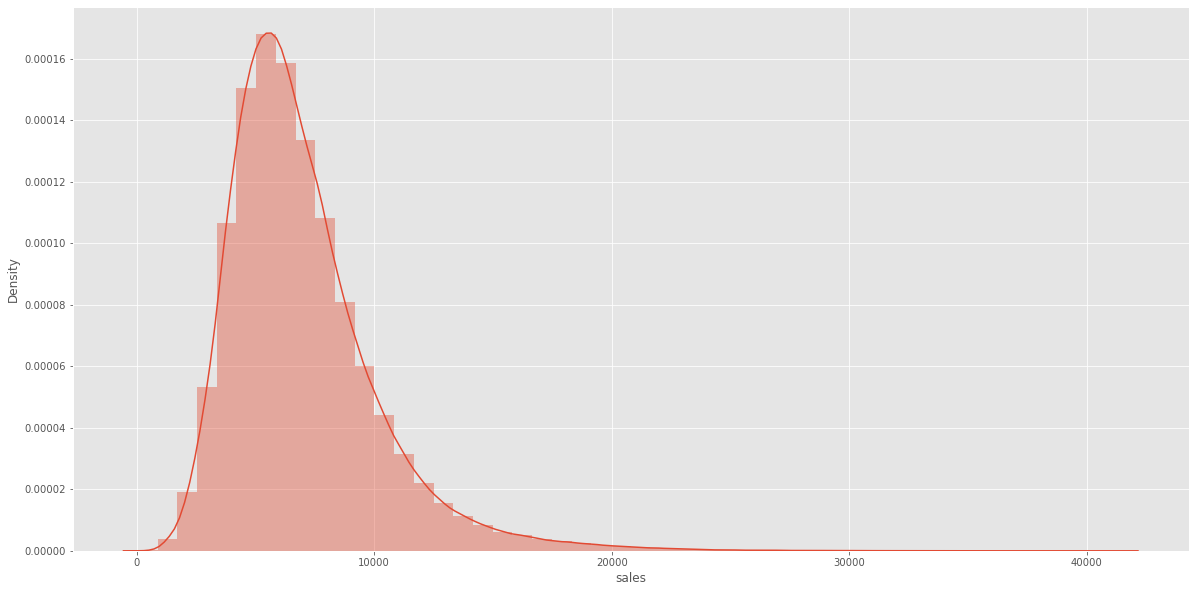

In [85]:
plt.figure(figsize=(20, 10))
sns.distplot(df_eda['sales'])
plt.show()

Finally, the boxplots below show the relationship between the sales and categorical features. 

Some observations we can make are:

* Store type b has a higher average sales than the other types. 
* Surprisingly, an intermediate assortment (b) has a higher average sales than an extended assortment (c).
* Sales on holidays tend to have much more variance compared to sales on working days.

<AxesSubplot:xlabel='assortment', ylabel='sales'>

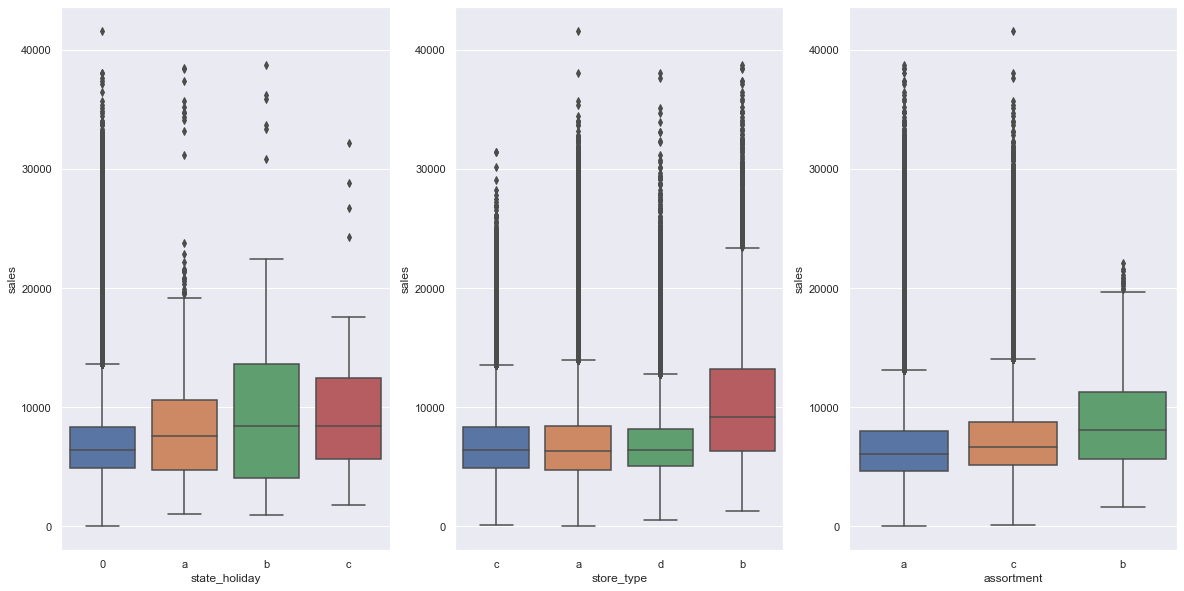

In [116]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=df_eda)
plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=df_eda)
plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=df_eda)

# 5. Machine Learning Models

The following sections present many possibilities of machine learning models. We start with simple linear regression and then increase the complexity.

## 5.1 Linear Regression

In [193]:
linear_regression_pipeline = Pipeline(steps=[('missing_value_imputer', MissingValueImputer()),
                                             ('attributes_adder', AttributesAdder()),
                                             ('scaler', Scaler()),
                                             ('encoder', Encoder()),
                                             ('feature_selection', SelectPercentile(mutual_info_regression, percentile=65)),
                                             ('model', TransformedTargetRegressor(LinearRegression(), func=np.log1p, inverse_func=np.expm1))
                                             ])
linear_regression_pipeline

Pipeline(steps=[('missing_value_imputer', MissingValueImputer()),
                ('attributes_adder', AttributesAdder()), ('scaler', Scaler()),
                ('encoder', Encoder()),
                ('feature_selection',
                 SelectPercentile(percentile=100,
                                  score_func=<function mutual_info_regression at 0x7f7e129ad280>)),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=LinearRegression()))])

In [194]:
linear_regression_cv_results = cross_validate(linear_regression_pipeline, X_train, y_train,
                                              scoring=['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error','neg_root_mean_squared_error'],
                                              cv=TimeSeriesCV(n_splits=5, gap=14),
                                              error_score='raise',
                                              n_jobs=-1
                                              )

linear_regression_cv_df = cv_results_to_dataframe(linear_regression_cv_results, 'Linear Regression')

linear_regression_cv_df

,Model Name,MAE CV,MAPE CV,RMSE CV,Mean Fit Time (min),Mean Score Time (min)
0,Linear Regression,1899.92 +/- 117.41,0.28 +/- 0.0,2713.23 +/- 182.88,6.01 +/- 0.37,0.04 +/- 0.01


## 5.2 Lasso Regression

In [208]:
lasso_pipeline = Pipeline(steps=[('missing_value_imputer', MissingValueImputer()),
                                 ('attributes_adder', AttributesAdder()),
                                 ('scaler', Scaler()),
                                 ('encoder', Encoder()),
                                #  ('feature_selection', SelectPercentile(mutual_info_regression, percentile=100)),
                                 ('model', TransformedTargetRegressor(Lasso(alpha=0.01), func=np.log1p, inverse_func=np.expm1))
                                ])
lasso_pipeline

Pipeline(steps=[('missing_value_imputer', MissingValueImputer()),
                ('attributes_adder', AttributesAdder()), ('scaler', Scaler()),
                ('encoder', Encoder()),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=Lasso(alpha=0.01)))])

In [209]:
lasso_cv_results = cross_validate(lasso_pipeline, X_train, y_train,
                                  scoring=['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error','neg_root_mean_squared_error'],
                                  cv=TimeSeriesCV(n_splits=5, gap=14),
                                  error_score='raise',
                                  n_jobs=-1
                                  )

lasso_cv_df = cv_results_to_dataframe(lasso_cv_results, 'Lasso')

lasso_cv_df

,Model Name,MAE CV,MAPE CV,RMSE CV,Mean Fit Time (min),Mean Score Time (min)
0,Lasso,1948.87 +/- 132.01,0.29 +/- 0.01,2811.78 +/- 219.46,1.52 +/- 0.16,0.06 +/- 0.02


## 5.3 Random Forests

In [268]:
rf_pipeline = Pipeline(steps=[('missing_value_imputer', MissingValueImputer()),
                              ('attributes_adder', AttributesAdder()),
                              ('scaler', Scaler()),
                              ('encoder', Encoder()),
                            #   ('feature_selection', SelectPercentile(mutual_info_regression, percentile=100)),
                              ('model', TransformedTargetRegressor(RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=1), func=np.log1p, inverse_func=np.expm1))
                              ])
rf_pipeline

Pipeline(steps=[('missing_value_imputer', MissingValueImputer()),
                ('attributes_adder', AttributesAdder()), ('scaler', Scaler()),
                ('encoder', Encoder()),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=RandomForestRegressor(n_estimators=50,
                                                                            n_jobs=-1,
                                                                            random_state=1)))])

In [269]:
rf_cv_results = cross_validate(rf_pipeline, X_train, y_train,
                               scoring=['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error','neg_root_mean_squared_error'],
                               cv=TimeSeriesCV(n_splits=5, gap=14),
                               error_score='raise',
                               n_jobs=-1
                               )

random_forest_cv_df = cv_results_to_dataframe(rf_cv_results, 'Random Forest')

random_forest_cv_df

,Model Name,MAE CV,MAPE CV,RMSE CV,Mean Fit Time (min),Mean Score Time (min)
0,Random Forest,794.99 +/- 99.04,0.12 +/- 0.01,1191.5 +/- 151.95,5.92 +/- 0.63,5.29 +/- 5.81


## 5.4 XGBoost

In [273]:
xgb_pipeline = Pipeline(steps=[('missing_value_imputer', MissingValueImputer()),
                               ('attributes_adder', AttributesAdder()),
                               ('scaler', Scaler()),
                               ('encoder', Encoder()),
                            #    ('feature_selection', SelectPercentile(mutual_info_regression, percentile=100)),
                               ('model', TransformedTargetRegressor(xgb.XGBRegressor(objective='reg:squarederror'), func=np.log1p, inverse_func=np.expm1))
                                ])
xgb_pipeline

Pipeline(steps=[('missing_value_imputer', MissingValueImputer()),
                ('attributes_adder', AttributesAdder()), ('scaler', Scaler()),
                ('encoder', Encoder()),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=XGBRegressor(base_score=None,
                                                                   booster=None,
                                                                   colsample_bylevel=None,
                                                                   colsample_bynode=None,
                                                                   colsample_bytree=None,
                                                                   en...
                                                                   interaction_constraints=None,
                                                                   learning_rate=None,
                                                                   max_delta_step=None,
                                                                   max_depth=None,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   n_estimators=100,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None,
                                                                   predictor=None,
                                                                   random_state=None,
                                                                   reg_alpha=None,
                                                                   reg_lambda=None,
                                                                   scale_pos_weight=None,
                                                                   subsample=None,
                                                                   tree_method=None,
                                                                   validate_parameters=None,
                                                                   verbosity=None)))])

In [275]:
xgb_cv_results = cross_validate(xgb_pipeline, X_train, y_train,
                                scoring=['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error','neg_root_mean_squared_error'],
                                cv=TimeSeriesCV(n_splits=5, gap=14),
                                error_score='raise',
                                n_jobs=-1
                                )

xgb_cv_df = cv_results_to_dataframe(xgb_cv_results, 'XGB')

xgb_cv_df

/Users/lucasstelmastchuk/opt/anaconda3/envs/ds_em_producao_lucas1/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/lucasstelmastchuk/opt/anaconda3/envs/ds_em_producao_lucas1/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/lucasstelmastchuk/opt/anaconda3/envs/ds_em_producao_lucas1/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/lucasstelmastchuk/opt/anaconda3/envs/ds_em_producao_lu

,Model Name,MAE CV,MAPE CV,RMSE CV,Mean Fit Time (min),Mean Score Time (min)
0,XGB,1008.06 +/- 71.98,0.14 +/- 0.0,1450.7 +/- 109.26,4.59 +/- 0.38,0.13 +/- 0.06


## 5.5 Histogram Gradient Boosting

In [265]:
hgb_pipeline = Pipeline(steps=[('missing_value_imputer', MissingValueImputer()),
                              ('attributes_adder', AttributesAdder()),
                              ('scaler', Scaler()),
                              ('encoder', Encoder()),
                            #   ('feature_selection', SelectPercentile(mutual_info_regression, percentile=100)),
                              ('model', TransformedTargetRegressor(HistGradientBoostingRegressor(max_leaf_nodes=80), func=np.log1p, inverse_func=np.expm1))
                              ])
hgb_pipeline

Pipeline(steps=[('missing_value_imputer', MissingValueImputer()),
                ('attributes_adder', AttributesAdder()), ('scaler', Scaler()),
                ('encoder', Encoder()),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=HistGradientBoostingRegressor(max_leaf_nodes=80)))])

In [266]:
hgb_cv_results = cross_validate(hgb_pipeline, X_train, y_train,
                               scoring=['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error','neg_root_mean_squared_error'],
                               cv=TimeSeriesCV(n_splits=5, gap=14),
                               error_score='raise',
                               n_jobs=-1
                               )

hgb_cv_df = cv_results_to_dataframe(hgb_cv_results, 'Hist Gradient Boosting')

hgb_cv_df

,Model Name,MAE CV,MAPE CV,RMSE CV,Mean Fit Time (min),Mean Score Time (min)
0,Hist Gradient Boosting,1155.48 +/- 85.58,0.16 +/- 0.0,1662.6 +/- 130.39,1.68 +/- 0.1,0.05 +/- 0.01


## 5.6 LightGBM

In [262]:
lgbm_pipeline = Pipeline(steps=[('missing_value_imputer', MissingValueImputer()),
                                ('attributes_adder', AttributesAdder()),
                                ('scaler', Scaler()),
                                ('encoder', Encoder()),
                                # ('feature_selection', SelectPercentile(mutual_info_regression, percentile=100)),
                                ('model', TransformedTargetRegressor(LGBMRegressor(num_leaves=50), func=np.log1p, inverse_func=np.expm1))
                                ])

lgbm_pipeline

Pipeline(steps=[('missing_value_imputer', MissingValueImputer()),
                ('attributes_adder', AttributesAdder()), ('scaler', Scaler()),
                ('encoder', Encoder()),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=LGBMRegressor(num_leaves=50)))])

In [263]:
lgbm_cv_results = cross_validate(lgbm_pipeline, X_train, y_train,
                                scoring=['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error','neg_root_mean_squared_error'],
                                cv=TimeSeriesCV(n_splits=5, gap=14),
                                error_score='raise',
                                n_jobs=-1
                                )

lgbm_cv_df = cv_results_to_dataframe(lgbm_cv_results, 'LightGBM')

lgbm_cv_df

,Model Name,MAE CV,MAPE CV,RMSE CV,Mean Fit Time (min),Mean Score Time (min)
0,LightGBM,1264.32 +/- 95.87,0.18 +/- 0.0,1811.91 +/- 153.44,1.22 +/- 0.12,0.07 +/- 0.03


## 5.7 Model Performance Comparison

In [276]:
models_cv = pd.concat([linear_regression_cv_df, lasso_cv_df, random_forest_cv_df, xgb_cv_df, hgb_cv_df, lgbm_cv_df]).reset_index(drop=True)

models_cv

,Model Name,MAE CV,MAPE CV,RMSE CV,Mean Fit Time (min),Mean Score Time (min)
0,Linear Regression,1899.92 +/- 117.41,0.28 +/- 0.0,2713.23 +/- 182.88,6.01 +/- 0.37,0.04 +/- 0.01
1,Lasso,1948.87 +/- 132.01,0.29 +/- 0.01,2811.78 +/- 219.46,1.52 +/- 0.16,0.06 +/- 0.02
2,Random Forest,794.99 +/- 99.04,0.12 +/- 0.01,1191.5 +/- 151.95,5.92 +/- 0.63,5.29 +/- 5.81
3,XGB,1008.06 +/- 71.98,0.14 +/- 0.0,1450.7 +/- 109.26,4.59 +/- 0.38,0.13 +/- 0.06
4,Hist Gradient Boosting,1155.48 +/- 85.58,0.16 +/- 0.0,1662.6 +/- 130.39,1.68 +/- 0.1,0.05 +/- 0.01
5,LightGBM,1264.32 +/- 95.87,0.18 +/- 0.0,1811.91 +/- 153.44,1.22 +/- 0.12,0.07 +/- 0.03


The best performing model was random forests. However, its mean fit time was much higher than LightGBM, which was the fastest. As LightGBM is a highly tunable model, we can expect to significantly improve its performance with hyperparameter optimization.

To speed up LightGBM tuning, we will use a bayesian optimization algorithm implemented in the Optuna package.

# 6. Bayesian Hyperparameter Optimization with Optuna

## 6.1 Defining the objective function

In [57]:
def objective(trial, X, y):
    param_grid = {
        'attributes_adder__cyclical_features': trial.suggest_categorical('attributes_adder__cyclical_features', [True, False]),
        'feature_selection__percentile': trial.suggest_int("feature_selection_percentile", 60, 100, step=10),
        'model__n_estimators': trial.suggest_categorical("n_estimators", [10000]),
        'model__learning_rate': trial.suggest_float("learning_rate", 0.01, 0.3),
        'model__num_leaves': trial.suggest_int("num_leaves", 20, 3000, step=20),
        "model__max_depth": trial.suggest_int("max_depth", 3, 12),
        "model__min_child_samples": trial.suggest_int("min_child_samples", 200, 10000, step=100),
        "model__reg_alpha": trial.suggest_int("reg_alpha", 0, 100, step=5),
        "model__reg_lambda": trial.suggest_int("reg_lambda", 0, 100, step=5),
        "model__min_split_gain": trial.suggest_float("min_split_gain", 0, 15),
        "model__subsample": trial.suggest_float("subsample", 0.2, 0.95, step=0.1),
        "model__subsample_freq": trial.suggest_categorical("subsample_freq", [1]),
        "model__colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 0.95, step=0.1)
    }

    lgbm_pipeline_tuning = Pipeline(steps=[('missing_value_imputer', MissingValueImputer()),
                                           ('attributes_adder', AttributesAdder()),
                                           ('scaler', Scaler()),
                                           ('encoder', Encoder()),
                                           ('feature_selection', SelectPercentile(mutual_info_regression, percentile=100)),
                                           ('model', LGBMRegressor())
                                           ])

    lgbm_pipeline_tuning.set_params(**param_grid)

    X_transformed = lgbm_pipeline_tuning[:-1].fit_transform(X, y)

    cv = TimeSeriesCV(n_splits=5, gap=14)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X)):
        X_training, X_testing = X_transformed[train_idx], X_transformed[test_idx]
        y_training, y_testing = np.log1p(y.iloc[train_idx].values), np.log1p(y.iloc[test_idx].values)

        lgbm_pipeline_tuning[-1].fit(
            X_training,
            y_training,
            eval_set=[(X_testing, y_testing)],
            early_stopping_rounds=100,
            callbacks=[LightGBMPruningCallback(trial, "l2")]  # Add a pruning callback
        )

        predictions = lgbm_pipeline_tuning[-1].predict(X_testing)
        cv_scores[idx] = mean_squared_error(np.expm1(y_testing), np.expm1(predictions))**0.5

    return np.mean(cv_scores)

## 6.2 Running the optimization

In [61]:
study = optuna.create_study(direction="minimize", study_name='LGBM Regressor')
func = lambda trial: objective(trial, X_train, y_train)
study.optimize(func, n_trials=100)

[I 2022-08-23 18:44:28,250] A new study created in memory with name: LGBM Regressor
[I 2022-08-23 18:48:22,970] Trial 0 finished with value: 2650.091909189582 and parameters: {'attributes_adder__cyclical_features': True, 'feature_selection_percentile': 70, 'n_estimators': 10000, 'learning_rate': 0.19333340546619382, 'num_leaves': 1420, 'max_depth': 5, 'min_child_samples': 2300, 'reg_alpha': 75, 'reg_lambda': 75, 'min_split_gain': 14.97501594886276, 'subsample': 0.2, 'subsample_freq': 1, 'colsample_bytree': 0.5}. Best is trial 0 with value: 2650.091909189582.
[I 2022-08-23 18:52:23,933] Trial 1 finished with value: 2343.3267428716144 and parameters: {'attributes_adder__cyclical_features': True, 'feature_selection_percentile': 70, 'n_estimators': 10000, 'learning_rate': 0.2988100180779501, 'num_leaves': 2140, 'max_depth': 12, 'min_child_samples': 5200, 'reg_alpha': 85, 'reg_lambda': 80, 'min_split_gain': 3.3874861568700076, 'subsample': 0.5, 'subsample_freq': 1, 'colsample_bytree': 0.600

In [64]:
study.optimize(func, n_trials=100)

[I 2022-08-24 09:33:02,058] Trial 100 finished with value: 1466.5402640632153 and parameters: {'attributes_adder__cyclical_features': True, 'feature_selection_percentile': 90, 'n_estimators': 10000, 'learning_rate': 0.26564443489328393, 'num_leaves': 2940, 'max_depth': 11, 'min_child_samples': 400, 'reg_alpha': 15, 'reg_lambda': 100, 'min_split_gain': 0.26693910814556415, 'subsample': 0.8, 'subsample_freq': 1, 'colsample_bytree': 0.9}. Best is trial 81 with value: 1348.0991631627655.
[I 2022-08-24 09:37:06,001] Trial 101 pruned. Trial was pruned at iteration 487.
[I 2022-08-24 09:41:19,368] Trial 102 finished with value: 1501.0697271892561 and parameters: {'attributes_adder__cyclical_features': True, 'feature_selection_percentile': 100, 'n_estimators': 10000, 'learning_rate': 0.26656255546404484, 'num_leaves': 2860, 'max_depth': 12, 'min_child_samples': 300, 'reg_alpha': 10, 'reg_lambda': 100, 'min_split_gain': 0.543455792197815, 'subsample': 0.9, 'subsample_freq': 1, 'colsample_bytree

In [136]:
study.optimize(func, n_trials=100)

[I 2022-08-24 21:45:19,911] Trial 200 pruned. Trial was pruned at iteration 8.
[I 2022-08-24 22:17:34,223] Trial 201 finished with value: 1401.5011754492625 and parameters: {'attributes_adder__cyclical_features': True, 'feature_selection_percentile': 100, 'n_estimators': 10000, 'learning_rate': 0.2954555924814179, 'num_leaves': 2740, 'max_depth': 11, 'min_child_samples': 200, 'reg_alpha': 0, 'reg_lambda': 25, 'min_split_gain': 0.2456054031064223, 'subsample': 0.9, 'subsample_freq': 1, 'colsample_bytree': 0.9}. Best is trial 136 with value: 1213.7796834809433.
[I 2022-08-24 22:21:31,570] Trial 202 finished with value: 1425.5599292374827 and parameters: {'attributes_adder__cyclical_features': True, 'feature_selection_percentile': 100, 'n_estimators': 10000, 'learning_rate': 0.29431317562288833, 'num_leaves': 2720, 'max_depth': 11, 'min_child_samples': 200, 'reg_alpha': 0, 'reg_lambda': 25, 'min_split_gain': 0.29827940132291936, 'subsample': 0.9, 'subsample_freq': 1, 'colsample_bytree': 0

## 6.3 Graphing the results

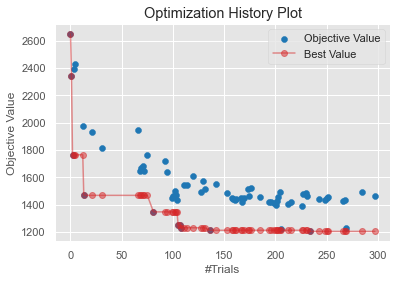

In [190]:
from optuna.visualization.matplotlib import plot_optimization_history
plot_optimization_history(study)
plt.show()

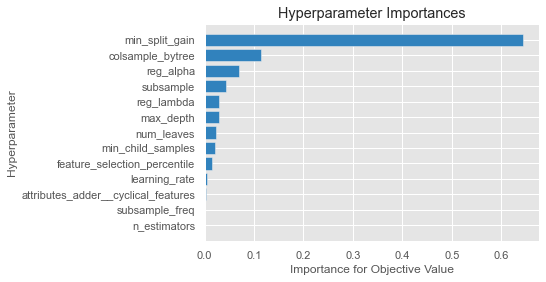

In [191]:
optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()

In [192]:
print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (rmse): 1205.31261
	Best params:
		attributes_adder__cyclical_features: True
		feature_selection_percentile: 100
		n_estimators: 10000
		learning_rate: 0.26270827151084397
		num_leaves: 2840
		max_depth: 12
		min_child_samples: 400
		reg_alpha: 0
		reg_lambda: 30
		min_split_gain: 0.005564682383302044
		subsample: 0.9
		subsample_freq: 1
		colsample_bytree: 0.9


## 6.4 Final model

In [254]:
lgbm_pipeline_tuned = Pipeline(steps=[('missing_value_imputer', MissingValueImputer()),
                                ('attributes_adder', AttributesAdder()),
                                ('scaler', Scaler()),
                                ('encoder', Encoder()),
                                ('model', TransformedTargetRegressor(LGBMRegressor(n_estimators=10000,
                                                                                  learning_rate=0.05,
                                                                                  num_leaves=2840,
                                                                                  max_depth=12,
                                                                                  min_child_samples=400,
                                                                                  reg_alpha=0,
                                                                                  reg_lambda=30,
                                                                                  min_split_gain=0.005564682383302044,
                                                                                  subsample=0.9,
                                                                                  subsample_freq=1,
                                                                                  colsample_bytree=0.9),
                                                                    func=np.log1p, inverse_func=np.expm1))])

feature_names = lgbm_pipeline_tuned[:-1].fit_transform(X_train, y_train).columns

In [255]:
lgbm_pipeline_tuned.fit(X_train, y_train)

Pipeline(steps=[('missing_value_imputer', MissingValueImputer()),
                ('attributes_adder', AttributesAdder()), ('scaler', Scaler()),
                ('encoder', Encoder()),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=LGBMRegressor(colsample_bytree=0.9,
                                                                    learning_rate=0.05,
                                                                    max_depth=12,
                                                                    min_child_samples=400,
                                                                    min_split_gain=0.005564682383302044,
                                                                    n_estimators=10000,
                                                                    num_leaves=2840,
                                                                    reg_alpha=0,
                                                                    reg_lambda=30,
                                                                    subsample=0.9,
                                                                    subsample_freq=1)))])

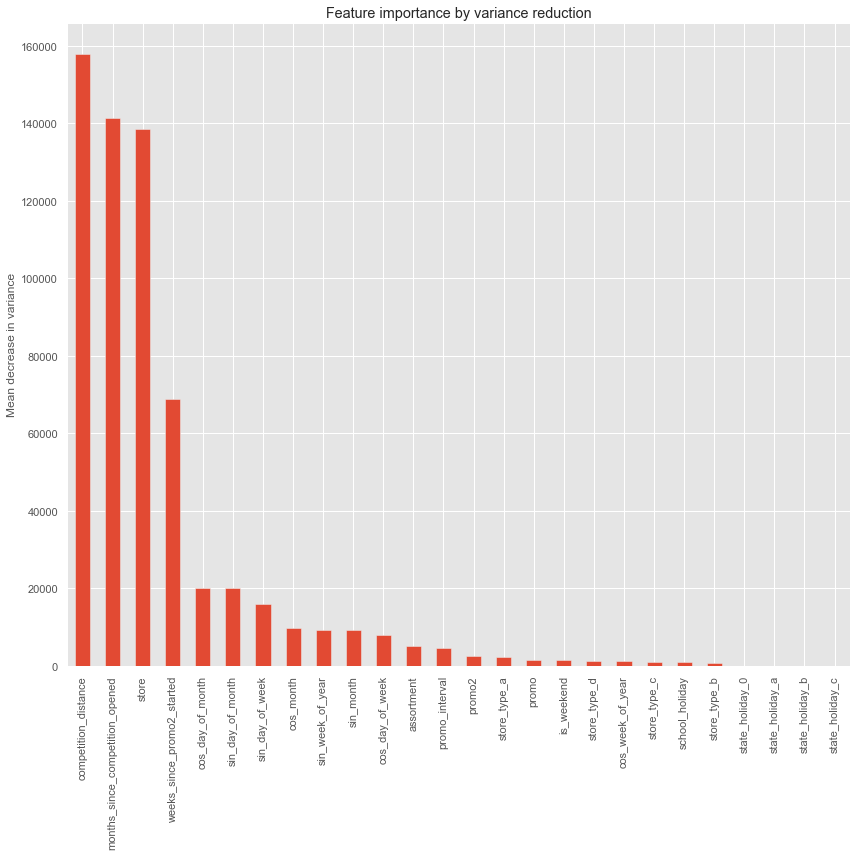

In [256]:
feature_importances = lgbm_pipeline_tuned[-1].regressor_.feature_importances_
feature_importances = pd.Series(feature_importances, index=feature_names).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 12))
feature_importances.plot.bar(ax=ax)
ax.set_title("Feature importance by variance reduction")
ax.set_ylabel("Mean decrease in variance")
fig.tight_layout()

The plot of feature importance shows that competition distance is the most important feature for the model. 

# 7. Kaggle Submission

In [257]:
predictions = lgbm_pipeline_tuned.predict(X_test)
submission = pd.concat([df_raw_test['id'], pd.Series(predictions)], axis=1)
submission.columns = ['Id', 'Sales']
submission.to_csv('submission.csv', index=False)

The submission achieved a score of 0.13218 on the private leaderboard, which contains 67% of test data. This model might be a good starting point for further development.

In a real world scenario, the ultimate criterion to decide whether the model brings value to the company is to compare it with predictions made by the managers. Even if it gives predictions at a similar level of accuracy, it could be employed to save time that managers spend on such predictions.  